In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import os

In [2]:
def evaluate_logreg_kfold():
    metrics = {
        'train': {'accuracy': [], 'precision': [], 'recall': [], 'f1_macro': [], 'f1_weighted': [], 'f1_class0': [], 'f1_class1': []},
        'test': {'accuracy': [], 'precision': [], 'recall': [], 'f1_macro': [], 'f1_weighted': [], 'f1_class0': [], 'f1_class1': []}
    }
    global train_conf_matrices, test_conf_matrices
    train_conf_matrices = []
    test_conf_matrices = []
    label_column = 'y'

    for i in range(1, 11):
        train_path = f'testData/kfold_fold_{i}_train.csv'
        test_path = f'testData/kfold_fold_{i}_test.csv'
        df_train = pd.read_csv(train_path)
        df_test = pd.read_csv(test_path)

        X_train = df_train.drop(label_column, axis=1)
        y_train = df_train[label_column]
        X_test = df_test.drop(label_column, axis=1)
        y_test = df_test[label_column]

        model = LogisticRegression(solver='liblinear')
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        for dataset, y_true, y_pred in [('train', y_train, y_train_pred), ('test', y_test, y_test_pred)]:
            metrics[dataset]['accuracy'].append(accuracy_score(y_true, y_pred))
            metrics[dataset]['precision'].append(precision_score(y_true, y_pred, zero_division=0))
            metrics[dataset]['recall'].append(recall_score(y_true, y_pred, zero_division=0))
            metrics[dataset]['f1_macro'].append(f1_score(y_true, y_pred, average='macro', zero_division=0))
            metrics[dataset]['f1_weighted'].append(f1_score(y_true, y_pred, average='weighted', zero_division=0))
            metrics[dataset]['f1_class0'].append(f1_score(y_true, y_pred, pos_label=0, zero_division=0))
            metrics[dataset]['f1_class1'].append(f1_score(y_true, y_pred, pos_label=1, zero_division=0))

        train_conf_matrices.append(confusion_matrix(y_train, y_train_pred))
        test_conf_matrices.append(confusion_matrix(y_test, y_test_pred))

        print(f"Fold {i} - Train Accuracy: {metrics['train']['accuracy'][-1]:.4f}, Test Accuracy: {metrics['test']['accuracy'][-1]:.4f}")

    return metrics

In [3]:
metrics = evaluate_logreg_kfold()

Fold 1 - Train Accuracy: 0.8986, Test Accuracy: 0.8981
Fold 2 - Train Accuracy: 0.9010, Test Accuracy: 0.8981
Fold 3 - Train Accuracy: 0.8988, Test Accuracy: 0.9005
Fold 4 - Train Accuracy: 0.8991, Test Accuracy: 0.8932
Fold 5 - Train Accuracy: 0.8978, Test Accuracy: 0.8981
Fold 6 - Train Accuracy: 0.9015, Test Accuracy: 0.8859
Fold 7 - Train Accuracy: 0.8972, Test Accuracy: 0.9175
Fold 8 - Train Accuracy: 0.9013, Test Accuracy: 0.8762
Fold 9 - Train Accuracy: 0.8994, Test Accuracy: 0.9102
Fold 10 - Train Accuracy: 0.8997, Test Accuracy: 0.8929


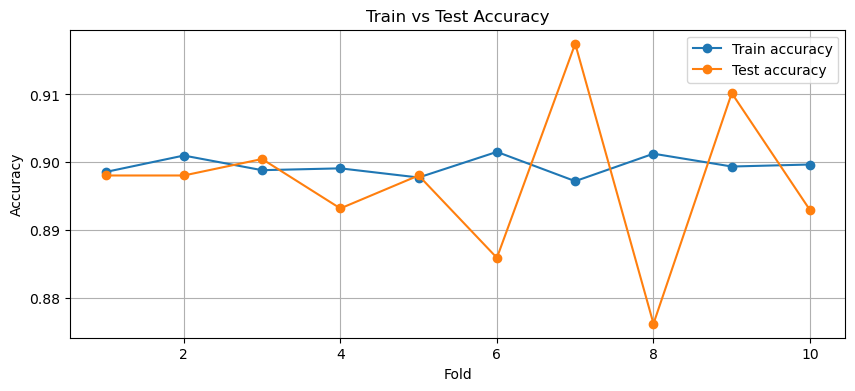

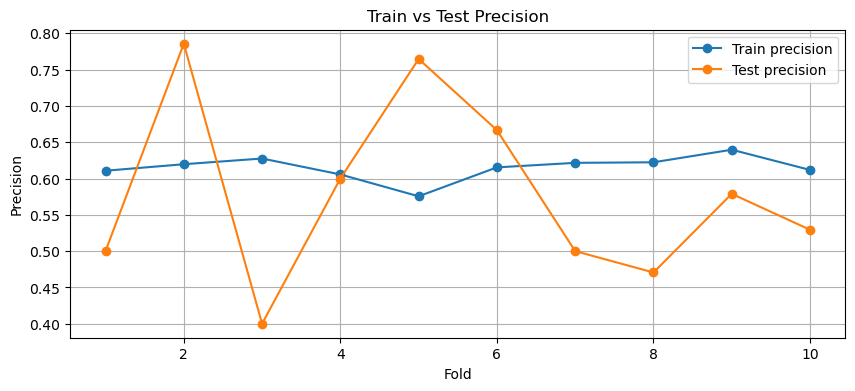

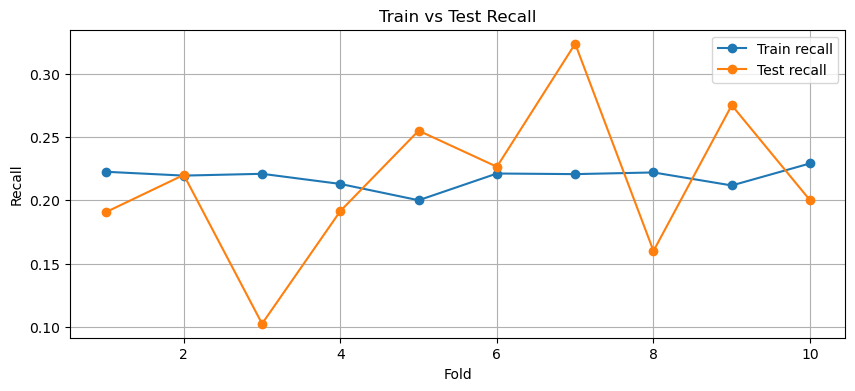

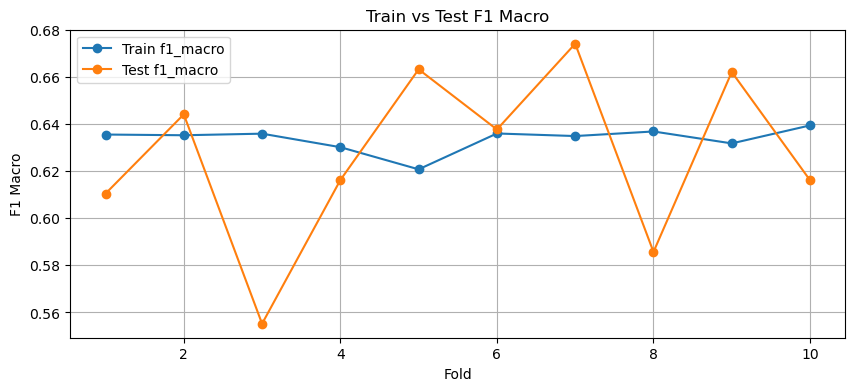

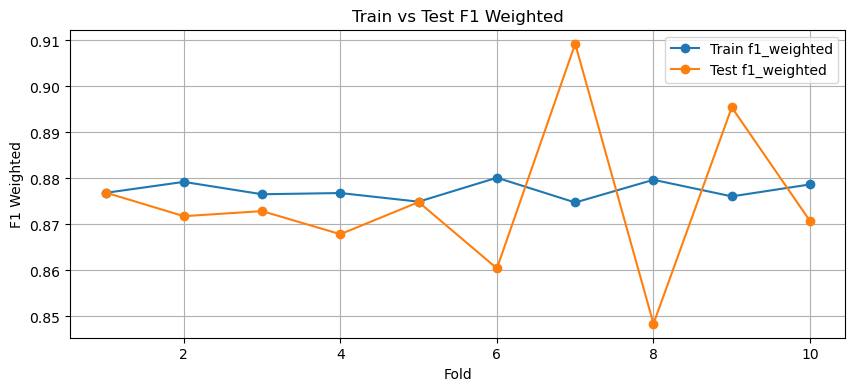

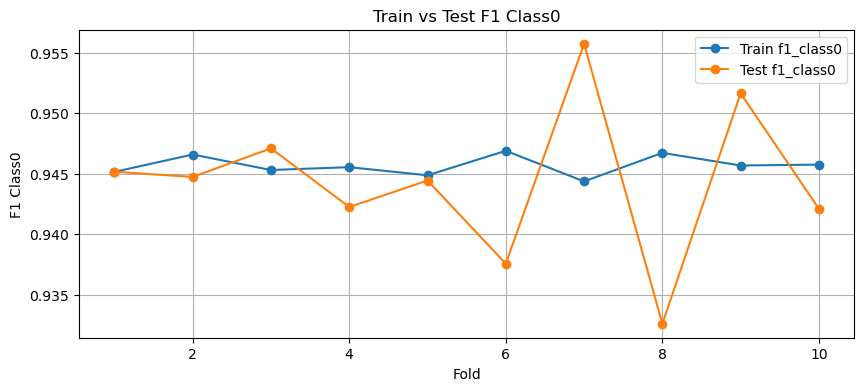

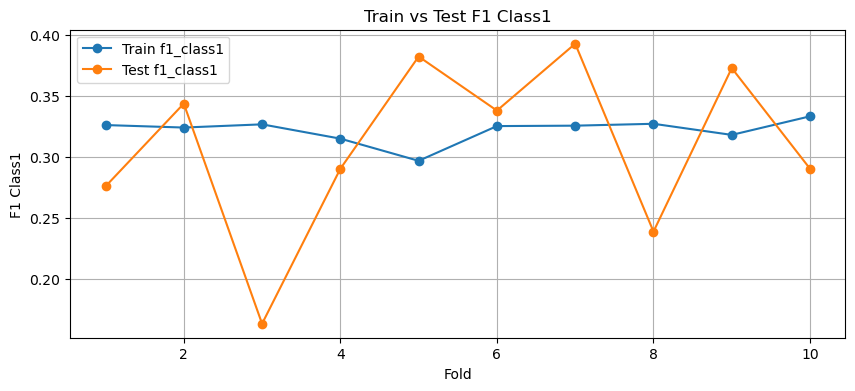

In [4]:
# 📊 Visualize all Train vs Test Metrics
folds = list(range(1, 11))
measures = ['accuracy', 'precision', 'recall', 'f1_macro', 'f1_weighted', 'f1_class0', 'f1_class1']

for measure in measures:
    plt.figure(figsize=(10, 4))
    plt.plot(folds, metrics['train'][measure], marker='o', label=f'Train {measure}')
    plt.plot(folds, metrics['test'][measure], marker='o', label=f'Test {measure}')
    plt.title(f'Train vs Test {measure.replace('_', ' ').title()}')
    plt.xlabel('Fold')
    plt.ylabel(measure.replace('_', ' ').title())
    plt.legend()
    plt.grid(True)
    plt.show()

In [5]:
# 📋 Summary Table and CSV Export
summary_data = {}
for split in ['train', 'test']:
    for metric, values in metrics[split].items():
        summary_data[f'{split}_{metric}_mean'] = [np.mean(values)]
        summary_data[f'{split}_{metric}_std'] = [np.std(values)]

summary_df = pd.DataFrame(summary_data).T
summary_df.columns = ['Value']
summary_df.to_excel('logreg_metrics_report.xlsx')
summary_df

,Value
train_accuracy_mean,0.899436
train_accuracy_std,0.001385
train_precision_mean,0.615015
train_precision_std,0.016008
train_recall_mean,0.218011
train_recall_std,0.007585
train_f1_macro_mean,0.633772
train_f1_macro_std,0.004941
train_f1_weighted_mean,0.877390
train_f1_weighted_std,0.001843


In [6]:
# 🧩 Save Confusion Matrices
os.makedirs('confusion_matrices_logreg/train', exist_ok=True)
os.makedirs('confusion_matrices_logreg/test', exist_ok=True)

for i in range(10):
    fig, ax = plt.subplots()
    ConfusionMatrixDisplay(train_conf_matrices[i]).plot(ax=ax)
    plt.title(f'Train Confusion Matrix - Fold {i+1}')
    plt.savefig(f'confusion_matrices_logreg/train/fold_{i+1}.png')
    plt.close()

    fig, ax = plt.subplots()
    ConfusionMatrixDisplay(test_conf_matrices[i]).plot(ax=ax)
    plt.title(f'Test Confusion Matrix - Fold {i+1}')
    plt.savefig(f'confusion_matrices_logreg/test/fold_{i+1}.png')
    plt.close()

print('Saved all confusion matrices.')

Saved all confusion matrices.
